In [ ]:
# !pip install pandas numpy matplotlib seaborn scikit-learn nltk gensim wordcloud

Defaulting to user installation because normal site-packages is not writeable


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import nltk
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from wordcloud import WordCloud
from collections import defaultdict
from sklearn.metrics import pairwise_distances

**Data Processing**

In [2]:
paper_path = '../../dataset/papers.csv'
author_path = '../../dataset/authors.csv'
paper_authors_path = '../../dataset/paper_authors.csv'

df_paper = pd.read_csv(paper_path, on_bad_lines='skip')
df_author = pd.read_csv(author_path)
df_paper_author = pd.read_csv(paper_authors_path)

df_paper.head()


,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [8]:
print(len(df_paper))

7241


In [9]:
# --- 2. Link Paper ID and Author Name ---
# Merge the paper_author and author tables to obtain the author name for each paper
df_merged_authors = pd.merge(
    df_paper_author,
    df_author[['id', 'name']],
    left_on='author_id',
    right_on='id',
    how='left'
)

df_merged_authors.head()

,id_x,paper_id,author_id,id_y,name
0,1,63,94,94,Yaser S. Abu-Mostafa
1,2,80,124,124,Joshua Alspector
2,3,80,125,125,Robert B. Allen
3,4,80,126,126,Victor Hu
4,5,80,127,127,Srinagesh Satyanarayana


In [10]:
df_aggregated_authors = (
    df_merged_authors
    .groupby('paper_id')['name']
    .apply(list)
    .reset_index()
)

df_aggregated_authors.rename(columns={'name': 'authors_list'}, inplace=True)
df_aggregated_authors.head()

,paper_id,authors_list
0,1,"[Hisashi Suzuki, Suguru Arimoto]"
1,2,[Philip A. Chou]
2,3,"[Eric B. Baum, Frank Wilczek]"
3,4,"[John C. Platt, Alan H. Barr]"
4,5,[Ralph Linsker]


In [11]:
df_final = pd.merge(
    df_paper,
    df_aggregated_authors,
    left_on='id',
    right_on='paper_id',
    how='left'            # Use a left join to preserve all original papers.
)

df_final.drop('paper_id', axis=1, inplace=True)
df_final.head()

,id,year,title,event_type,pdf_name,abstract,paper_text,authors_list
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,"[Hisashi Suzuki, Suguru Arimoto]"
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,[Christopher L. Scofield]
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,"[Patric K. Stanton, Terrence J. Sejnowski]"
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...,"[Gerhard Paass, J?rg Kindermann]"
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a...","[Anders Krogh, Jesper Vedelsby]"


In [12]:
df_final.isnull().sum()

id                 0
year               0
title              0
event_type      4819
pdf_name           0
abstract           0
paper_text         0
authors_list       3
dtype: int64

In [13]:
df_final = df_final.dropna(subset=['authors_list'])
df_final = df_final.drop(columns=['id', 'event_type', 'pdf_name'])
df_final.reset_index(drop=True, inplace=True)

In [14]:
df_final.head()

,year,title,abstract,paper_text,authors_list
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,"[Hisashi Suzuki, Suguru Arimoto]"
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,[Christopher L. Scofield]
2,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,"[Patric K. Stanton, Terrence J. Sejnowski]"
3,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...,"[Gerhard Paass, J?rg Kindermann]"
4,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a...","[Anders Krogh, Jesper Vedelsby]"


In [15]:
missing_count = (df_final['abstract'] == 'Abstract Missing').sum()
print(f"The number of Abstract Missing : {missing_count}")
print(f"Percentage of Abstract Missing ​​in total data: {missing_count/len(df_final):.2%}")

The number of Abstract Missing : 3317
Percentage of Abstract Missing ​​in total data: 45.83%


In [16]:
def abstract_extraction_enhancement(df):
    """
    Enhanced abstract extraction function
    Handles the following cases:
    1. Standard format with ABSTRACT keyword
    2. Format without ABSTRACT but directly starting abstract content
    3. Extract first paragraph from INTRODUCTION as fallback
    """
    def extract_abstract(text):
        if pd.isna(text) or text == '':
            return 'Abstract Missing'

        # Preprocessing: remove special characters, normalize line breaks
        text = re.sub(r'\x0c', '', text)  # Remove form feed character
        text = re.sub(r'\n\s*\n', '\n\n', text)  # Normalize empty lines

        # Strategy 1: Standard ABSTRACT extraction
        patterns = [
            r'ABSTRACT[^\w]*(.*?)(?=\nINTRODUCTION)',
            r'ABSTRACT[^\w]*(.*?)(?=\n\s*\d+\.)',
            r'ABSTRACT[^\w]*(.*?)(?=\n[A-Z][A-Z\s]{15,})',
            r'ABSTRACT[^\w]*(.*?)(?=\n\s*\n\s*[A-Z])',
        ]

        for pattern in patterns:
            match = re.search(pattern, text, re.DOTALL | re.IGNORECASE)
            if match:
                abstract = match.group(1).strip()
                abstract = re.sub(r'\s+', ' ', abstract)
                if 50 < len(abstract) < 1500:  # Reasonable abstract length range
                    return abstract

        # Strategy 2: Cases without ABSTRACT but directly starting abstract content
        lines = [line.strip() for line in text.split('\n') if line.strip()]

        author_patterns = [
            r'University', r'Institute', r'Laboratory',
            r'Department', r'Center', r'U\.S\.A\.', r'USA'
        ]

        intro_patterns = [
            r'INTRODUCTION', r'1\.', r'I\.',
            r'BACKGROUND', r'METHODS', r'EXPERIMENTAL'
        ]

        in_abstract = False
        abstract_lines = []

        for i, line in enumerate(lines):
            # Check if passed author information section
            if not in_abstract and any(re.search(p, line) for p in author_patterns):
                in_abstract = True
                continue

            # Check if entered introduction section
            if any(re.search(p, line, re.IGNORECASE) for p in intro_patterns):
                break

            if in_abstract and len(line.split()) > 3:  # At least 3 words to avoid title lines
                if (len(line) > 30 and
                    not line.isupper() and
                    not re.match(r'^[A-Z][A-Z\s]{15,}$', line)):
                    abstract_lines.append(line)
                    if len(abstract_lines) >= 3:  # Take at most 3 paragraphs
                        break

        if abstract_lines:
            abstract = ' '.join(abstract_lines)
            abstract = re.sub(r'\s+', ' ', abstract)
            if 50 < len(abstract) < 1500:
                return abstract

        # Strategy 3: Extract first paragraph from INTRODUCTION as last resort
        intro_match = re.search(
            r'(?:INTRODUCTION|1\.|I\.|BACKGROUND)\s*(.*?)(?=\n\s*\n|\n\d+\.|\n[A-Z][A-Z\s]{15,})',
            text,
            re.DOTALL | re.IGNORECASE
        )
        if intro_match:
            intro_text = intro_match.group(1).strip()
            first_paragraph = re.split(r'\n\s*\n', intro_text)[0]
            first_paragraph = re.sub(r'\s+', ' ', first_paragraph)
            if len(first_paragraph) > 50:
                return f"[Extracted from Introduction] {first_paragraph[:500]}"  # Limit length

        return 'Abstract Missing'

    # Only process rows with missing abstracts
    mask = df['abstract'] == 'Abstract Missing'
    print(f"Missing abstracts before processing: {mask.sum()}")

    df.loc[mask, 'abstract'] = df.loc[mask, 'paper_text'].apply(extract_abstract)

    print(f"Missing abstracts after processing: {(df['abstract'] == 'Abstract Missing').sum()}")
    return df

In [17]:
df_integrate_final = abstract_extraction_enhancement(df_final)
df_integrate_final.head()

Missing abstracts before processing: 3317
Missing abstracts after processing: 12


,year,title,abstract,paper_text,authors_list
0,1987,Self-Organization of Associative Database and ...,An efficient method of self-organizing associa...,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,"[Hisashi Suzuki, Suguru Arimoto]"
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,A single cell theory for the development of se...,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,[Christopher L. Scofield]
2,1988,Storing Covariance by the Associative Long-Ter...,In modeling studies or memory based on neural ...,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,"[Patric K. Stanton, Terrence J. Sejnowski]"
3,1994,Bayesian Query Construction for Neural Network...,"If data collection is costly, there is much to...",Bayesian Query Construction for Neural\nNetwor...,"[Gerhard Paass, J?rg Kindermann]"
4,1994,"Neural Network Ensembles, Cross Validation, an...",Learning of continuous valued functions using ...,"Neural Network Ensembles, Cross\nValidation, a...","[Anders Krogh, Jesper Vedelsby]"


In [18]:
# Delete rows where the abstract column still reads 'Abstract Missing'
df_integrate_final = df_integrate_final[df_integrate_final['abstract'] != 'Abstract Missing']

# Verify the results after deletion
print(f"Number of papers remaining after deletion: {len(df_integrate_final)}")

missing_count = (df_integrate_final['abstract'] == 'Abstract Missing').sum()
print(f"The number of Abstract Missing: {missing_count}")
print(f"Percentage of Abstract Missing ​​in total data: {missing_count/len(df_integrate_final):.2%}")

Number of papers remaining after deletion: 7226
The number of Abstract Missing: 0
Percentage of Abstract Missing ​​in total data: 0.00%


In [19]:
df_integrate_final.head()

,year,title,abstract,paper_text,authors_list
0,1987,Self-Organization of Associative Database and ...,An efficient method of self-organizing associa...,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,"[Hisashi Suzuki, Suguru Arimoto]"
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,A single cell theory for the development of se...,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,[Christopher L. Scofield]
2,1988,Storing Covariance by the Associative Long-Ter...,In modeling studies or memory based on neural ...,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,"[Patric K. Stanton, Terrence J. Sejnowski]"
3,1994,Bayesian Query Construction for Neural Network...,"If data collection is costly, there is much to...",Bayesian Query Construction for Neural\nNetwor...,"[Gerhard Paass, J?rg Kindermann]"
4,1994,"Neural Network Ensembles, Cross Validation, an...",Learning of continuous valued functions using ...,"Neural Network Ensembles, Cross\nValidation, a...","[Anders Krogh, Jesper Vedelsby]"


In [20]:
df_integrate_final.to_csv('processed_data.csv', index=False)

In [21]:
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
    nltk.download('wordnet')
warnings.filterwarnings("ignore", category=UserWarning, module="gensim")
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...


**Preliminary data analysis**

In [22]:
# Load data
df = df_integrate_final.copy()

# Basic data exploration
print("Basic data information:")
print(f"Data shape: {df.shape}")
print(f"Year range: {df['year'].min()} - {df['year'].max()}")
print("\nFirst 5 rows:")
print(df.head())

# Check missing values
print("\nMissing values statistics:")
print(df.isnull().sum())

Basic data information:
Data shape: (7226, 5)
Year range: 1987 - 2017

First 5 rows:
   year                                              title  \
0  1987  Self-Organization of Associative Database and ...   
1  1987  A Mean Field Theory of Layer IV of Visual Cort...   
2  1988  Storing Covariance by the Associative Long-Ter...   
3  1994  Bayesian Query Construction for Neural Network...   
4  1994  Neural Network Ensembles, Cross Validation, an...   

                                            abstract  \
0  An efficient method of self-organizing associa...   
1  A single cell theory for the development of se...   
2  In modeling studies or memory based on neural ...   
3  If data collection is costly, there is much to...   
4  Learning of continuous valued functions using ...   

                                          paper_text  \
0  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...   
1  683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...   
2  394\n\nSTORING COVARIANCE BY THE A

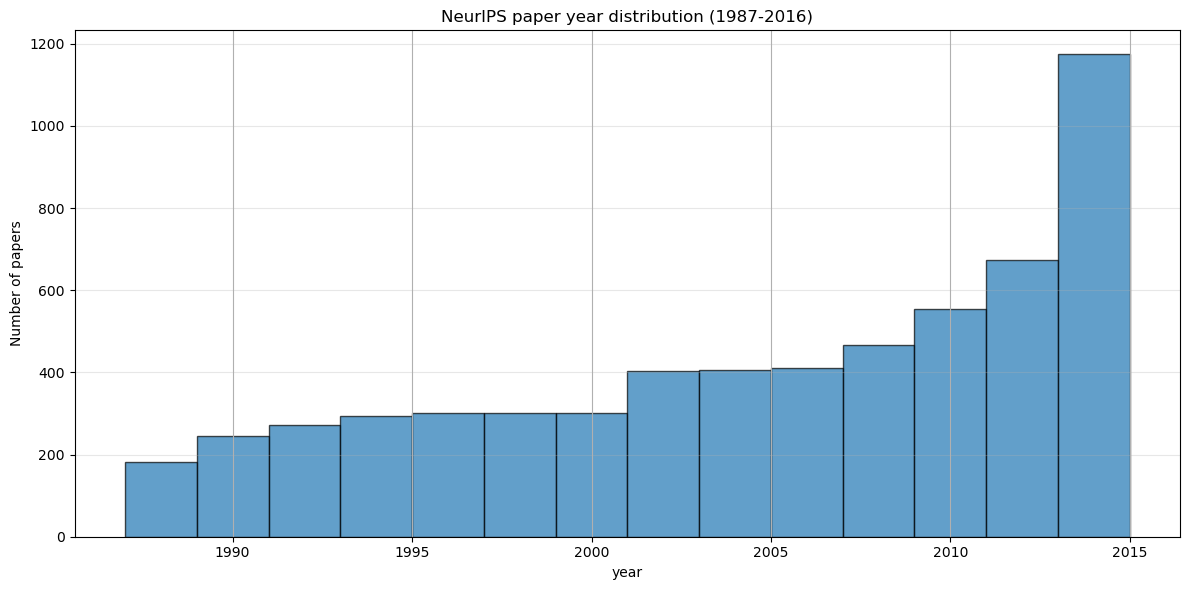

In [23]:
# Year distribution visualization
plt.figure(figsize=(12, 6))
df['year'].hist(bins=range(1987, 2017, 2), alpha=0.7, edgecolor='black')
plt.title('NeurIPS paper year distribution (1987-2016)')
plt.xlabel('year')
plt.ylabel('Number of papers')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Topic Modelling**

In [24]:
def preprocess_text(text):
    """
    Text preprocessing function - optimized for full paper_text
    """
    if pd.isna(text):
        return []

    # Convert to lowercase
    text = text.lower()

    # Special cleaning for full text: remove citation markers, numbers, URLs, etc.
    text = re.sub(r'\[.*?\]', '', text)  # Remove citation markers [1], [2-5], etc.
    text = re.sub(r'\b\d+\b', '', text)  # Remove pure numbers
    text = re.sub(r'http\S+', '', text)   # Remove URLs
    text = re.sub(r'fig\.|figure|table|section|equation', '', text)  # Remove figure/table descriptions

    # Remove special characters but keep basic words
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Tokenization
    words = text.split()

    # Extended stop words list (optimized for full text characteristics)
    stop_words = set(stopwords.words('english'))
    custom_stopwords = [
        'from', 'subject', 're', 'edu', 'use', 'paper', 'study', 'result',
        'method', 'propose', 'show', 'present', 'approach', 'based', 'model',
        'algorithm', 'problem', 'result', 'experiment', 'data', 'figure',
        'table', 'section', 'chapter', 'reference', 'acknowledge', 'introduction',
        'conclusion', 'abstract', 'keyword', 'reference', 'appendix', 'proof',
        'theorem', 'lemma', 'corollary', 'definition', 'example', 'note',
        'remark', 'assumption', 'hypothesis', 'wikipedia', 'journal', 'conference'
    ]
    stop_words.update(custom_stopwords)

    # Stricter filtering (full text has larger vocabulary, needs stronger filtering)
    words = [word for word in words if word not in stop_words and len(word) > 3]  # Length > 3

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return words  # Return token list instead of string

In [25]:
# Apply text preprocessing
print("Starting text preprocessing...")
df['processed_words'] = df['paper_text'].apply(preprocess_text)

# Remove empty documents and documents that are too short
df = df[df['processed_words'].apply(lambda x: len(x) > 10)]  # At least 10 words

print(f"Number of documents after processing: {len(df)}")
print("Preprocessing examples:")
print("Original text snippet:", df['paper_text'].iloc[0][:100] + "...")
print("Number of cleaned words:", len(df['processed_words'].iloc[0]))
print("Example words:", df['processed_words'].iloc[0][:10])

# Create gensim dictionary and corpus (optimized for full text)
print("\n=== Creating gensim dictionary and corpus ===")
texts = df['processed_words'].tolist()

# Apply stricter filtering when creating dictionary
id2word = corpora.Dictionary(texts)
# Extreme value filtering: words must appear in at least 5 documents, not more than 50% of documents, keep at most 2000 words
id2word.filter_extremes(no_below=5, no_above=0.5, keep_n=2000)

corpus = [id2word.doc2bow(text) for text in texts]

print(f"Vocabulary size: {len(id2word)}")
print(f"Corpus size: {len(corpus)}")
print(f"Average document length: {np.mean([len(text) for text in texts]):.1f} words")

Starting text preprocessing...
Number of documents after processing: 7222
Preprocessing examples:
Original text snippet: 767

SELF-ORGANIZATION OF ASSOCIATIVE DATABASE
AND ITS APPLICATIONS
Hisashi Suzuki and Suguru Arimot...
Number of cleaned words: 1573
Example words: ['self', 'organization', 'associative', 'database', 'application', 'hisashi', 'suzuki', 'suguru', 'arimoto', 'osaka']

=== Creating gensim dictionary and corpus ===
Vocabulary size: 2000
Corpus size: 7222
Average document length: 1974.7 words


In [26]:
# 1. Topic number optimization function
def find_optimal_topics(corpus, id2word, texts, max_topics=15):
    """Find the optimal number of topics using coherence score"""
    print("\n=== Finding optimal number of topics ===")

    coherence_values = []
    model_list = []
    topic_range = range(2, max_topics + 1)

    for num_topics in topic_range:
        print(f"Training with topics: {num_topics}/{max_topics}")

        try:
            # Use more stable parameter settings
            lda_model = gensim.models.ldamodel.LdaModel(
                corpus=corpus,
                id2word=id2word,
                num_topics=num_topics,
                random_state=42,
                passes=5,
                alpha='symmetric',
                eta='auto',
                iterations=100,
                per_word_topics=True
            )

            # Calculate coherence score
            coherence_model = CoherenceModel(
                model=lda_model,
                texts=texts,
                dictionary=id2word,
                coherence='c_v'
            )
            coherence_score = coherence_model.get_coherence()

            model_list.append(lda_model)
            coherence_values.append(coherence_score)
            print(f"Topics {num_topics}: Coherence score = {coherence_score:.4f}")

        except Exception as e:
            print(f"Topic {num_topics} training failed: {e}")
            coherence_values.append(0)
            model_list.append(None)

    # Filter out failed results
    valid_indices = [i for i, model in enumerate(model_list) if model is not None]
    if not valid_indices:
        raise ValueError("All topic number trainings failed!")

    valid_coherence = [coherence_values[i] for i in valid_indices]
    optimal_idx = valid_indices[np.argmax(valid_coherence)]
    optimal_topics = topic_range[optimal_idx]
    optimal_model = model_list[optimal_idx]

    print(f"Optimal number of topics: {optimal_topics}, Coherence score: {coherence_values[optimal_idx]:.4f}")

    # Plot coherence scores
    plt.figure(figsize=(10, 6))
    valid_topics = [topic_range[i] for i in valid_indices]
    plt.plot(valid_topics, valid_coherence, marker='o', linewidth=2, markersize=6)
    plt.axvline(x=optimal_topics, color='red', linestyle='--', alpha=0.7,
                label=f'Optimal Number of Topics: {optimal_topics}')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence score (c_v)')
    plt.title('Topic Number Optimization')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return optimal_model, optimal_topics, coherence_values[optimal_idx]

In [27]:
# 2. Model evaluation function
def evaluate_model(lda_model, corpus, texts, id2word):
    """Evaluate LDA model performance"""
    print("\n=== Model Evaluation ===")

    # Calculate perplexity (log perplexity)
    log_perplexity = lda_model.log_perplexity(corpus)
    print(f'Log perplexity: {log_perplexity:.4f} (lower is better)')

    # Calculate coherence score
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=texts,
        dictionary=id2word,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    print(f'Coherence score: {coherence_score:.4f} (higher is better)')

    return log_perplexity, coherence_score

In [28]:
# 3. Topic visualization function
def visualize_topics_wordcloud(lda_model, num_topics):
    """Generate topic word cloud visualization"""
    print("\n=== Generating Topic Word Clouds ===")

    # Calculate layout
    ncols = 4
    nrows = (num_topics + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4*nrows))
    if nrows == 1:
        axes = [axes] if ncols == 1 else axes
    else:
        axes = axes.flatten()

    for topic_idx in range(num_topics):
        # Get top 20 words and their weights for the topic
        topic_words = lda_model.show_topic(topic_idx, topn=20)
        word_freq_dict = {word: weight for word, weight in topic_words}

        # Generate word cloud
        wordcloud = WordCloud(
            width=400,
            height=300,
            background_color='white',
            colormap='viridis',
            random_state=42
        ).generate_from_frequencies(word_freq_dict)

        # Plot
        axes[topic_idx].imshow(wordcloud, interpolation='bilinear')
        axes[topic_idx].set_title(f'Topic {topic_idx+1}', fontsize=12, fontweight='bold')
        axes[topic_idx].axis('off')

    # Hide extra subplots
    for idx in range(num_topics, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

In [29]:
# 4. Display topic keywords
def display_topics_detailed(lda_model, num_topics, top_words=15):
    """Display detailed keywords for each topic"""
    print("\n=== Topic Keywords ===")
    topics_dict = {}

    for topic_idx in range(num_topics):
        topic_words = lda_model.show_topic(topic_idx, topn=top_words)
        words = [word for word, weight in topic_words]
        topics_dict[f'Topic_{topic_idx}'] = words

        print(f"\nTopic {topic_idx} (Top {top_words} keywords):")
        for i, (word, weight) in enumerate(topic_words):
            print(f"  {i+1:2d}. {word:<15} (weight: {weight:.4f})")

    return topics_dict

In [30]:
# 5. Assign topics to documents
def assign_topics_gensim(lda_model, corpus, df):
    """Assign topics to each paper"""
    print("\n=== Assigning Document Topics ===")

    dominant_topics = []
    topic_confidences = []

    for doc_bow in corpus:
        topic_probs = lda_model.get_document_topics(doc_bow)
        if topic_probs:
            dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
            confidence = max(topic_probs, key=lambda x: x[1])[1]
        else:
            dominant_topic = -1
            confidence = 0

        dominant_topics.append(dominant_topic)
        topic_confidences.append(confidence)

    df['dominant_topic'] = dominant_topics
    df['topic_confidence'] = topic_confidences

    # Display topic distribution
    topic_dist = df['dominant_topic'].value_counts().sort_index()
    print("Paper topic distribution:")
    for topic, count in topic_dist.items():
        print(f"Topic {topic}: {count} papers")

    return df

In [31]:
# 6. Topic evolution analysis
def analyze_topic_evolution(df, num_topics):
    """Analyze topic changes over time"""
    print("\n=== Topic Evolution Analysis ===")

    # Calculate topic distribution by year
    yearly_topic_dist = df.groupby('year')['dominant_topic'].value_counts().unstack().fillna(0)
    yearly_topic_percentage = yearly_topic_dist.div(yearly_topic_dist.sum(axis=1), axis=0)

    # Plot topic evolution stacked area chart
    plt.figure(figsize=(15, 8))
    yearly_topic_percentage.plot(kind='area', stacked=True, alpha=0.7)
    plt.title('Evolution of NeurIPS Paper Topics (1987-2016) - Full Text Analysis')
    plt.xlabel('Year')
    plt.ylabel('Topic Ratio')
    plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot trend lines for each topic
    plt.figure(figsize=(12, 6))
    for topic in range(num_topics):
        if topic in yearly_topic_percentage.columns:
            plt.plot(yearly_topic_percentage.index, yearly_topic_percentage[topic],
                     label=f'Topic {topic}', marker='o', markersize=3, linewidth=2)

    plt.title('Trends in Popularity of Each Topic Over Time - Full Text Analysis')
    plt.xlabel('Year')
    plt.ylabel('Topic Ratio')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return yearly_topic_percentage

In [32]:
# 7. Topic influence analysis
def calculate_topic_influence(lda_model, corpus, df, topics_dict, window_size=5):
    """Calculate topic influence"""
    print("\n=== Calculating Topic Influence ===")

    persistence_scores = {}

    for topic_id, keywords in topics_dict.items():
        topic_idx = int(topic_id.split('_')[1])

        # Keyword persistence analysis
        scores = []
        years = sorted(df['year'].unique())

        for i in range(len(years) - window_size):
            current_years = years[i:i+window_size]
            future_years = years[i+window_size:i+2*window_size]

            if len(future_years) > 0:
                current_mask = df['year'].isin(current_years)
                future_mask = df['year'].isin(future_years)

                current_papers = df[current_mask]
                future_papers = df[future_mask]

                if len(current_papers) > 0 and len(future_papers) > 0:
                    keyword_persistence = 0
                    for keyword in keywords[:5]:  # Only consider top 5 keywords
                        future_mentions = future_papers['processed_words'].apply(
                            lambda x: keyword in x).sum()
                        keyword_persistence += future_mentions / len(future_papers)

                    scores.append(keyword_persistence)

        persistence_scores[topic_id] = np.mean(scores) if scores else 0

    # Visualize topic influence
    plt.figure(figsize=(12, 6))
    topics = list(persistence_scores.keys())
    scores = list(persistence_scores.values())

    plt.bar(range(len(scores)), scores, color='skyblue', alpha=0.7)
    plt.title('Topic Influence Scores (Based on Keyword Persistence) - Full Text Analysis')
    plt.xlabel('Topic')
    plt.ylabel('Influence Score')
    plt.xticks(range(len(scores)), [f'T{i+1}' for i in range(len(scores))])
    plt.grid(axis='y', alpha=0.3)

    # Add value labels
    for i, score in enumerate(scores):
        plt.text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return persistence_scores

In [33]:
# 8. Author analysis
def analyze_authors(df):
    """Analyze author collaboration patterns and topic distribution"""
    print("\n=== Author Analysis ===")

    author_yearly_papers = defaultdict(lambda: defaultdict(int))
    author_topics = defaultdict(list)

    for idx, row in df.iterrows():
        authors = row['authors_list']
        year = row['year']
        topic = row['dominant_topic']

        for author in authors:
            author_yearly_papers[author][year] += 1
            author_topics[author].append(topic)

    # Find most productive authors
    productive_authors = sorted([(author, sum(papers.values()))
                               for author, papers in author_yearly_papers.items()],
                              key=lambda x: x[1], reverse=True)[:10]

    print("Top 10 most productive authors:")
    for i, (author, count) in enumerate(productive_authors, 1):
        print(f"{i:2d}. {author}: {count} papers")

    return author_yearly_papers, author_topics

In [34]:
# 9. Key findings summary
def generate_key_findings(df, yearly_topic_percentage, persistence_scores, coherence_score, num_topics):
    """Generate key findings summary"""
    print("\n=== Key Findings Summary ===")

    findings = {
        'total_papers': len(df),
        'time_span': f"{df['year'].min()}-{df['year'].max()}",
        'optimal_topics': num_topics,
        'coherence_score': coherence_score,
        'most_popular_topic': df['dominant_topic'].mode()[0],
        'trending_topics': {},
        'influential_topics': {}
    }

    # Identify trending topics
    for topic in range(num_topics):
        if topic in yearly_topic_percentage.columns:
            early_period = yearly_topic_percentage[yearly_topic_percentage.index < 2000][topic].mean()
            late_period = yearly_topic_percentage[yearly_topic_percentage.index >= 2010][topic].mean()

            if late_period > early_period + 0.02:  # Growth of more than 2%
                findings['trending_topics'][f'Topic_{topic}'] = {
                    'growth': late_period - early_period,
                    'influence': persistence_scores.get(f'Topic_{topic}', 0)
                }

    # Identify most influential topics
    influential_topics = sorted(persistence_scores.items(), key=lambda x: x[1], reverse=True)[:3]
    for topic_id, score in influential_topics:
        findings['influential_topics'][topic_id] = score

    # Print summary
    print(f"Total papers analyzed: {findings['total_papers']}")
    print(f"Time span: {findings['time_span']}")
    print(f"Optimal number of topics: {findings['optimal_topics']}")
    print(f"Model coherence score: {findings['coherence_score']:.4f}")
    print(f"Most popular topic: {findings['most_popular_topic']}")

    if findings['trending_topics']:
        print("\nTrending topics:")
        for topic, info in findings['trending_topics'].items():
            print(f"{topic}: Growth {info['growth']:.3f}, Influence {info['influence']:.3f}")

    if findings['influential_topics']:
        print("\nMost influential topics:")
        for topic, score in findings['influential_topics'].items():
            print(f"{topic}: Influence score {score:.3f}")

    return findings

In [35]:
# Main execution flow
def main():
    print("=== NeurIPS Paper Topic Modeling Analysis (Full Text Based) ===")

    # Use gensim for topic number optimization
    optimal_model, optimal_topics, best_coherence = find_optimal_topics(corpus, id2word, texts, max_topics=15)

    # Save model
    optimal_model.save("lda_model_fulltext.gensim")

    # Evaluate final model
    log_perplexity, coherence_score = evaluate_model(optimal_model, corpus, texts, id2word)

    # Display topic keywords
    topics_dict = display_topics_detailed(optimal_model, optimal_topics)

    # Assign topics to documents
    df_analyzed = assign_topics_gensim(optimal_model, corpus, df)

    # Topic visualization
    visualize_topics_wordcloud(optimal_model, optimal_topics)

    # Topic evolution analysis
    yearly_topic_percentage = analyze_topic_evolution(df_analyzed, optimal_topics)

    # Topic influence analysis
    persistence_scores = calculate_topic_influence(optimal_model, corpus, df_analyzed, topics_dict)

    # Author analysis
    author_papers, author_topics = analyze_authors(df_analyzed)

    # Key findings summary
    key_findings = generate_key_findings(df_analyzed, yearly_topic_percentage, persistence_scores,
                                       coherence_score, optimal_topics)

    print("\n=== Full Text Analysis Completed ===")

    return {
        'model': optimal_model,
        'topics_dict': topics_dict,
        'df_analyzed': df_analyzed,
        'yearly_topic_percentage': yearly_topic_percentage,
        'persistence_scores': persistence_scores,
        'key_findings': key_findings
    }

=== NeurIPS Paper Topic Modeling Analysis (Full Text Based) ===

=== Finding optimal number of topics ===
Training with topics: 2/15
Topics 2: Coherence score = 0.3966
Training with topics: 3/15
Topics 3: Coherence score = 0.4147
Training with topics: 4/15
Topics 4: Coherence score = 0.4538
Training with topics: 5/15
Topics 5: Coherence score = 0.5078
Training with topics: 6/15
Topics 6: Coherence score = 0.5116
Training with topics: 7/15
Topics 7: Coherence score = 0.5241
Training with topics: 8/15
Topics 8: Coherence score = 0.5373
Training with topics: 9/15
Topics 9: Coherence score = 0.5549
Training with topics: 10/15
Topics 10: Coherence score = 0.5453
Training with topics: 11/15
Topics 11: Coherence score = 0.5466
Training with topics: 12/15
Topics 12: Coherence score = 0.5405
Training with topics: 13/15
Topics 13: Coherence score = 0.5484
Training with topics: 14/15
Topics 14: Coherence score = 0.5498
Training with topics: 15/15
Topics 15: Coherence score = 0.5502
Optimal number

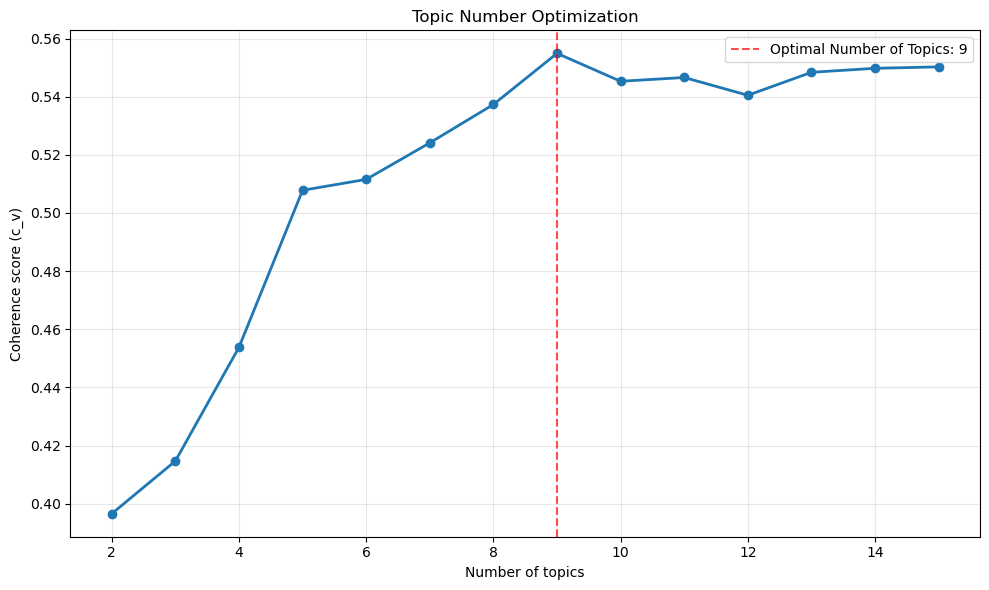


=== Model Evaluation ===
Log perplexity: -6.9297 (lower is better)
Coherence score: 0.5549 (higher is better)

=== Topic Keywords ===

Topic 0 (Top 15 keywords):
   1. cell            (weight: 0.0222)
   2. signal          (weight: 0.0174)
   3. response        (weight: 0.0172)
   4. neuron          (weight: 0.0168)
   5. stimulus        (weight: 0.0152)
   6. activity        (weight: 0.0116)
   7. visual          (weight: 0.0108)
   8. brain           (weight: 0.0101)
   9. field           (weight: 0.0095)
  10. filter          (weight: 0.0093)
  11. frequency       (weight: 0.0089)
  12. noise           (weight: 0.0085)
  13. correlation     (weight: 0.0084)
  14. spatial         (weight: 0.0075)
  15. direction       (weight: 0.0071)

Topic 1 (Top 15 keywords):
   1. graph           (weight: 0.0339)
   2. node            (weight: 0.0290)
   3. tree            (weight: 0.0190)
   4. cluster         (weight: 0.0175)
   5. clustering      (weight: 0.0171)
   6. edge            (weight

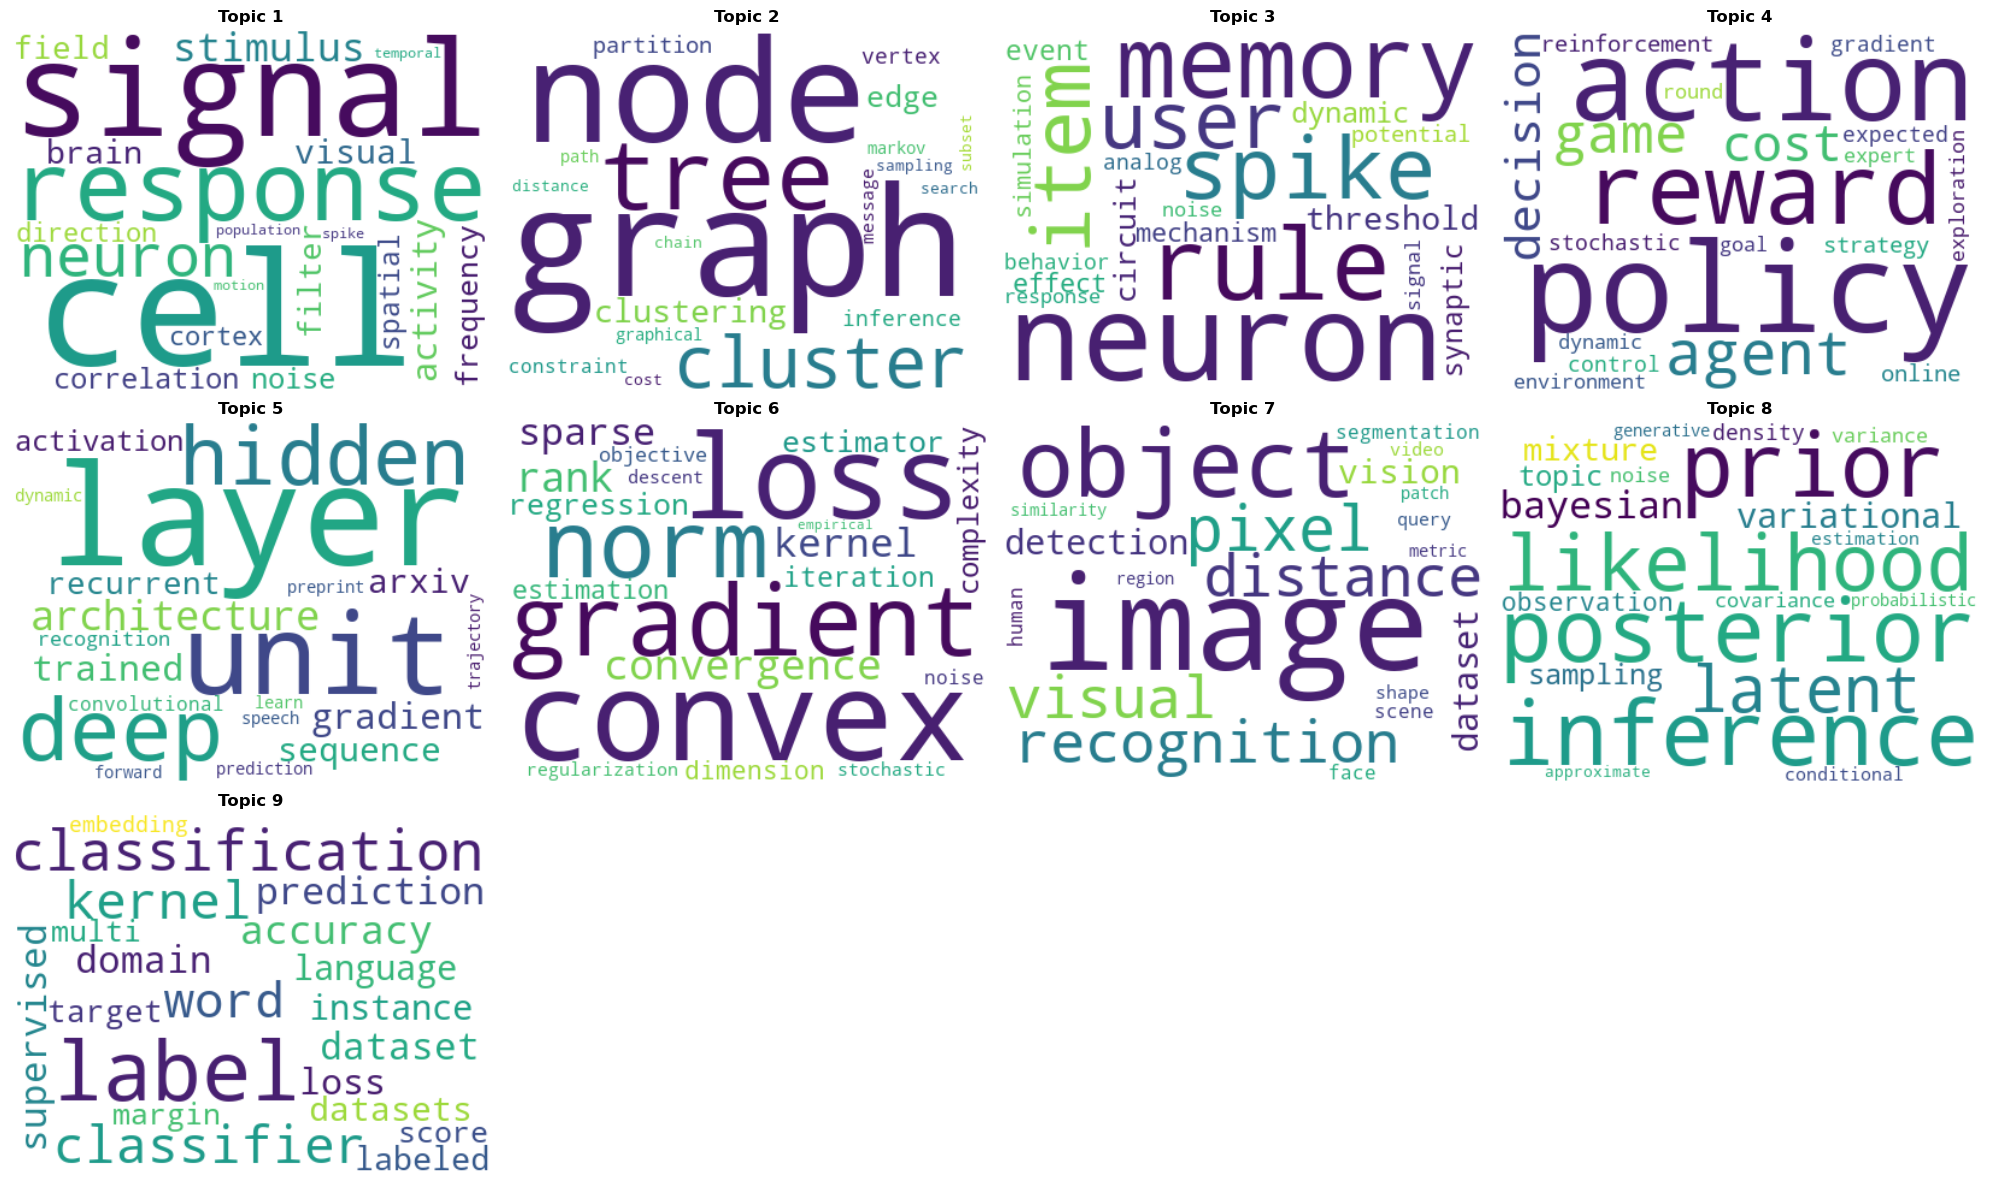


=== Topic Evolution Analysis ===


<Figure size 1500x800 with 0 Axes>

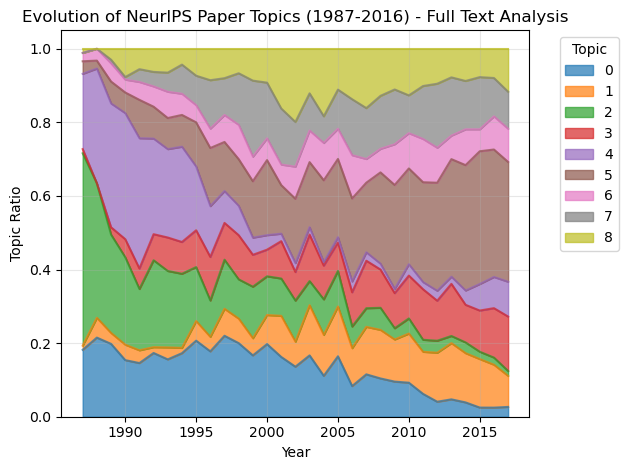

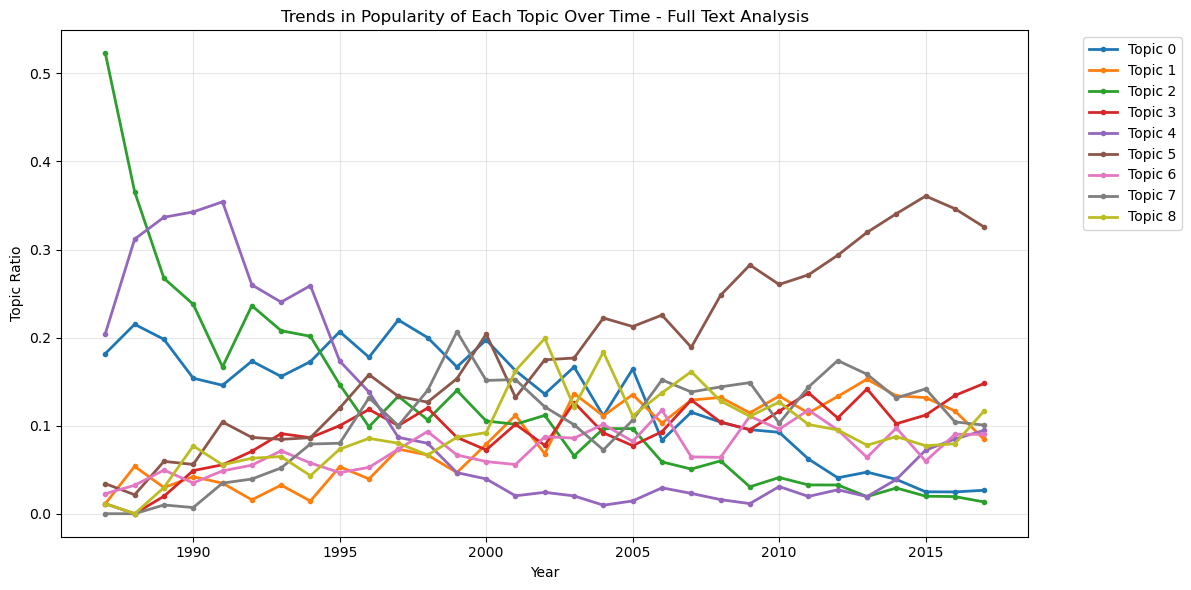


=== Calculating Topic Influence ===


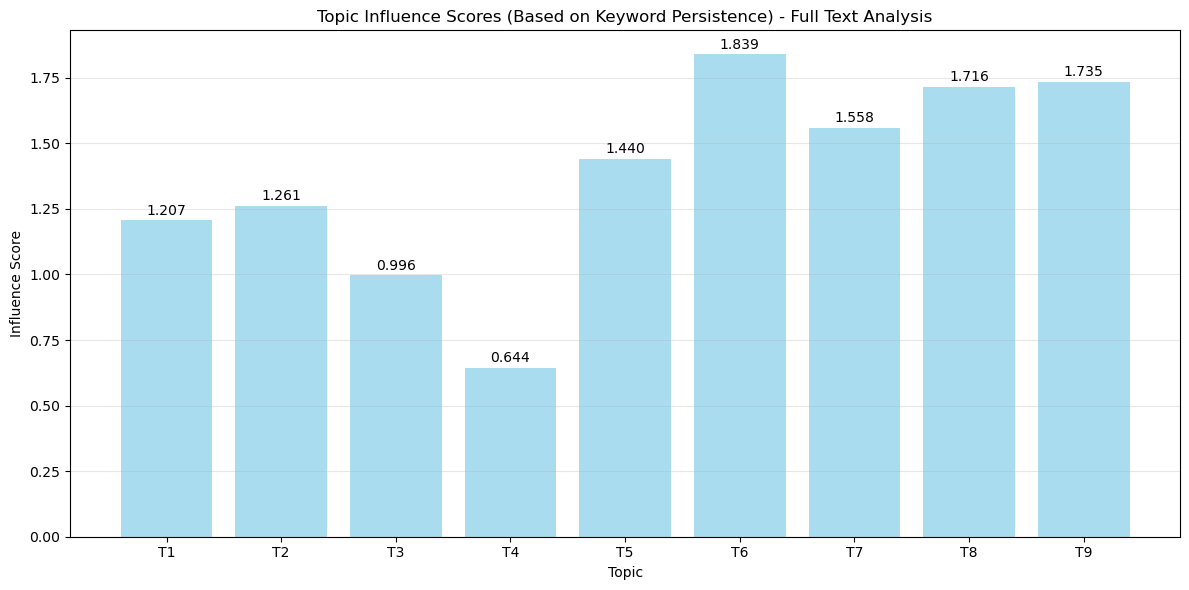


=== Author Analysis ===
Top 10 most productive authors:
 1. Michael I. Jordan: 101 papers
 2. Bernhard Sch?lkopf: 62 papers
 3. Yoshua Bengio: 60 papers
 4. Geoffrey E. Hinton: 58 papers
 5. Zoubin Ghahramani: 51 papers
 6. Terrence J. Sejnowski: 48 papers
 7. Peter Dayan: 47 papers
 8. Alex J. Smola: 41 papers
 9. Lawrence Carin: 41 papers
10. Andrew Y. Ng: 39 papers

=== Key Findings Summary ===
Total papers analyzed: 7222
Time span: 1987-2017
Optimal number of topics: 9
Model coherence score: 0.5549
Most popular topic: 5

Trending topics:
Topic_1: Growth 0.086, Influence 1.261
Topic_3: Growth 0.055, Influence 0.644
Topic_5: Growth 0.221, Influence 1.839
Topic_6: Growth 0.035, Influence 1.558
Topic_7: Growth 0.064, Influence 1.716
Topic_8: Growth 0.039, Influence 1.735

Most influential topics:
Topic_5: Influence score 1.839
Topic_8: Influence score 1.735
Topic_7: Influence score 1.716

=== Full Text Analysis Completed ===


In [36]:
# Run the main function
# Some words appear too infrequently in the corpus (cause warning)
# The vocabulary is too large but the amount of data is insufficient (cause warning)
if __name__ == "__main__":
    results = main()

**Classification**

Topic 0: Computational Neural Networks

Topic 1: Graph Models and Network Analysis

Topic 2: Memory and Dynamic Systems

Topic 3: Reinforcement Learning and Decision Theory

Topic 4: Deep Learning Architectures

Topic 5: Optimization Theory and Statistical Learning

Topic 6: Computer Vision

Topic 7: Bayesian Inference and Probabilistic Models

Topic 8: Supervised Learning and Classification

In [37]:
# Create a cross-tabulation
pd.crosstab(df['year'], df['dominant_topic'])

dominant_topic,0,1,2,3,4,5,6,7,8
year,,,,,,,,,
1987,16,1,46,1,18,3,2,0,1
1988,20,5,34,0,29,2,3,0,0
1989,20,3,27,2,34,6,5,1,3
1990,22,6,34,7,49,8,5,1,11
1991,21,5,24,8,51,15,7,5,8
1992,22,2,30,9,33,11,7,5,8
1993,24,5,32,14,37,13,11,8,10
1994,24,2,28,12,36,12,8,11,6
1995,31,8,22,15,26,18,7,12,11


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# TF-IDF feature extraction
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = tfidf.fit_transform(df['paper_text'])
y = df['dominant_topic']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train Logistic Regression
model = LogisticRegression(
    solver='saga',           # Suitable for multi-class classification and large-scale data
    multi_class='multinomial',  # Suitable for multi-class problems
    max_iter=1000,          # Increase iterations to ensure convergence
    random_state=42,        # Fixed random seed
    n_jobs=-1               # Use all CPU cores for acceleration
)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Calculate test set accuracy
test_accuracy = model.score(X_test, y_test)

print(f"Test set accuracy: {test_accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

E:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test set accuracy: 0.8699

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       133
           1       0.92      0.83      0.87       150
           2       0.89      0.74      0.81       122
           3       0.97      0.92      0.94       164
           4       0.79      0.85      0.82       109
           5       0.85      0.95      0.90       328
           6       0.91      0.86      0.88       118
           7       0.84      0.91      0.87       171
           8       0.83      0.79      0.81       150

    accuracy                           0.87      1445
   macro avg       0.87      0.85      0.86      1445
weighted avg       0.87      0.87      0.87      1445

